In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
import sys
if "google.colab" in sys.modules:
    !pip install Levenshtein
    !pip install unidecode
    !pip install emoji

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from tqdm.auto import tqdm
import os
import gc
import random
from glob import glob
from sklearn.model_selection import GroupKFold, KFold, StratifiedKFold
import warnings
import seaborn as sns
import re
from requests import get
from sklearn.neighbors import KNeighborsRegressor, NearestNeighbors
from difflib import SequenceMatcher
import lightgbm as lgb
import pickle
import Levenshtein
from sklearn.feature_extraction.text import TfidfVectorizer
from collections import defaultdict
from unidecode import unidecode
import emoji
import re

random.seed(42)
np.random.seed(42)
warnings.filterwarnings('ignore')

In [ ]:
if "google.colab" in sys.modules:
    expID = get("http://172.28.0.2:9000/api/sessions").json()[0]["name"].split(".")[0]
ROOT_PATH = '/content/drive/MyDrive/Kaggle/Foursquare'
INPUT_PATH = os.path.join(ROOT_PATH, 'input')
OUTPUT_PATH = os.path.join(os.path.join(ROOT_PATH, 'output'), expID)
MODEL_PATH = os.path.join(os.path.join(ROOT_PATH, 'models'), expID)
TARGET = 'point_of_interest'

In [ ]:
if not os.path.exists(OUTPUT_PATH):
    os.makedirs(OUTPUT_PATH)
if not os.path.exists(MODEL_PATH):
    os.makedirs(MODEL_PATH)

In [ ]:

N_NEIGHBORS = 100
NAME_RANK=5
ADDRESS_RANK = 3
CAT_RANK = 5
K_NEIGHBORS = 3
FILTER = 0.0
N_FOLD = 2
DISTANCE = 10000
CATEGORY_COUNT = 100
NAME_THRESHOLD = 0.4
CAT_THRESHOLD = 0.2

DEBUG = False
TFIDF = True
KDIST = True
NET = False # post processでは当たり前にやってた。# predの閾値は利用していなかったので、改良の余地あり。
MOJIBAKE = False
SAMPLING = False

def remove_emoji(src_str):
    return ''.join(c for c in src_str if c not in emoji.UNICODE_EMOJI)

In [ ]:
# with open(os.path.join(OUTPUT_PATH, 'name_variants.pkl'), mode='rb') as f:
#     name_dict = pickle.load(f)

In [ ]:
data = pd.read_csv(os.path.join(INPUT_PATH, 'train.csv'))
if DEBUG:
    data = data.iloc[:10000]
print(data.shape)

# cols = ['name', 'address', 'city', 'state']
cols = ['name']
# cols = ['name', 'address', 'city', 'state', 'zip', 'country', 'url', 'phone'] # categoriesは大文字が小文字になると困る。
for col in cols:
#     if col=='name':
#         data[col].update(data[col].map(name_dict))
    data[col] = data[col].fillna('').apply(unidecode)
    data[col] = data[col].str.lower()
    data[col] = data[col].apply(remove_emoji)

data.head()

(1138812, 13)


,id,name,latitude,longitude,address,city,state,zip,country,url,phone,categories,point_of_interest
0,E_000001272c6c5d,cafe stad oudenaarde,50.859975,3.634196,Abdijstraat,Nederename,Oost-Vlaanderen,9700,BE,NaN,NaN,Bars,P_677e840bb6fc7e
1,E_000002eae2a589,carioca manero,-22.907225,-43.178244,NaN,NaN,NaN,NaN,BR,NaN,NaN,Brazilian Restaurants,P_d82910d8382a83
2,E_000007f24ebc95,raantadphmkaaraaekd,13.780813,100.484900,NaN,NaN,NaN,NaN,TH,NaN,NaN,Salons / Barbershops,P_b1066599e78477
3,E_000008a8ba4f48,turkcell,37.844510,27.844202,Adnan Menderes Bulvarı,NaN,NaN,NaN,TR,NaN,NaN,Mobile Phone Shops,P_b2ed86905a4cd3
4,E_00001d92066153,restaurante casa cofino,43.338196,-4.326821,NaN,Caviedes,Cantabria,NaN,ES,NaN,NaN,Spanish Restaurants,P_809a884d4407fb


In [ ]:
def sub(x):
    return re.sub(r'[^a-zA-Z0-9 ]', ' ', x)
cols = ['name', 'address', 'city', 'state']
# cols = ['name']
for col in cols:
    data[col] = data[col].fillna('').apply(sub)
    data[f'{col}_split'] = data[col].str.split()

In [ ]:
if MOJIBAKE:
    data.loc[data['name'].str.contains('[买哪侈为裤溦发围货浓调时吧间价爱处灵节怎么办]', na=False), ['name', 'address', 'city']] = '<MOJIBAKE>'

In [ ]:
kf = GroupKFold(n_splits=N_FOLD)
for i, (_, val_idx) in enumerate(kf.split(data, data[TARGET], data[TARGET])):
    data.loc[val_idx, "cv"] = i
print(data["cv"].value_counts())

1.0    569406
0.0    569406
Name: cv, dtype: int64


# add Data

In [ ]:
with open(os.path.join(INPUT_PATH, 'id2com_30.pkl'), mode='rb') as f:
    id2com = pickle.load(f)
node_df = pd.read_csv(os.path.join(INPUT_PATH, 'node_df.csv'))
node_df.columns = ['main_category', 'id_code', 'adjacency_frequency', 'betweeness_centrality', 'clustering_coefficient', 'co_net']
node_df = node_df[['main_category', 'adjacency_frequency', 'betweeness_centrality', 'clustering_coefficient', 'co_net']]

def add_co_net(x):
    if x is np.nan:
        return np.nan
    out = -1
    for cat in x.split(', '):
        if cat in id2com.keys():
            out = id2com[cat]
            break

    return out

data['co_net'] = data['categories'].apply(add_co_net)

In [ ]:
def add_main_category(x):
    if x is np.nan:
        return np.nan

    return x.split(', ')[0]

data['main_category'] = data['categories'].apply(add_main_category)

In [ ]:
aggregated_df = pd.read_csv(os.path.join(INPUT_PATH, 'aggregated_df.csv'))
aggregated_df = aggregated_df.iloc[2:]
aggregated_df.columns = ['main_category', 'median_distances_max', 'median_distances_75', 'median_distances_median', 'median_distances_25', 'median_distances_min', 'count']

float_cols = ['median_distances_max', 'median_distances_75', 'median_distances_median', 'median_distances_25', 'median_distances_min']
aggregated_df[float_cols] = aggregated_df[float_cols].astype(float)
aggregated_df['count'] = aggregated_df['count'].astype(int)
aggregated_df['category_rate'] = aggregated_df['count'] / aggregated_df['count'].sum() # leakではない？

aggregated_df.head()


,main_category,median_distances_max,median_distances_75,median_distances_median,median_distances_25,median_distances_min,count,category_rate
2,ATMs,1.446457e+07,27032.192275,4490.248044,1012.594350,0.000000,1366,0.002505
3,Acai Houses,1.350800e+05,17781.269899,6117.784384,1359.040401,19.017952,25,0.000046
4,Accessories Stores,1.317399e+07,17636.724841,4397.253023,1609.960599,0.000000,890,0.001632
5,Acehnese Restaurants,1.394807e+05,28385.619678,11585.417039,6524.589277,308.232222,22,0.000040
6,Acupuncturists,1.099943e+06,30876.313672,5262.894842,1160.926141,0.000000,67,0.000123


In [ ]:
large_scales = list(aggregated_df[(aggregated_df['median_distances_median']>=DISTANCE) & (aggregated_df['count']>=CATEGORY_COUNT)].main_category)
small_scales = list(aggregated_df[(aggregated_df['median_distances_median']<DISTANCE) & (aggregated_df['count']>=CATEGORY_COUNT)].main_category)

def add_scale(x):
    categories = x.split(", ")
    out = -1
    for cat in categories:
        if cat in large_scales:
            out = 1
            break
        if cat in small_scales:
            out = 0
            break
    return out

data['scale'] = data['categories'].fillna('').apply(add_scale)
data.scale.value_counts()

 0    897808
 1    127772
-1    113232
Name: scale, dtype: int64

In [ ]:
cols = ['main_category', 'adjacency_frequency', 'betweeness_centrality', 'clustering_coefficient']
data= data.merge(node_df[cols], on='main_category', how='left')

cols = ['main_category', 'median_distances_median', 'category_rate'] # maxとかはリークな気がする。
data= data.merge(aggregated_df[cols], on='main_category', how='left')

In [ ]:
# category similarity
cats = data.categories.fillna('')

cat_stats = {}

for c in cats:
    csplit = c.split(", ")
    for c_ in csplit:
        if c_ not in cat_stats:
            cat_stats[c_] = [1, {ca: 1 for ca in csplit}]
        else:
            prev_cat_stats = cat_stats[c_]
            prev_cat_stats[0] += 1
            prev_sims = prev_cat_stats[1]
            
            for ca in csplit:
                prev_sims[ca] = prev_sims.get(ca, 0) + 1
        
for c, val in cat_stats.items():
    
    overall_count = sum(v for ca, v in val[1].items() if ca != c and v > 1)
    
    new_probs = {c: 1.0}
    if overall_count != 0:
        new_probs.update({ca: round(v / overall_count, 3) for ca, v in val[1].items() if v / overall_count > 0.01 and ca != c and v > 1})
        cat_stats[c] = [1.0, new_probs]
        
def get_cat_similarity(cat1, cat2):
    
    if cat1 == '' or cat2 == '':
        return 0.000000001
    
    if cat1 in cat2 or cat2 in cat1:
        return 1.0
    
    best = 0
    
    for c1 in cat1.split(", "):
        for c2 in cat2.split(", "):
            if c1 in cat_stats:
                best = max(best, cat_stats[c1][1].get(c2, 0))
            if c2 in cat_stats:
                best = max(best, cat_stats[c2][1].get(c1, 0))
    
    return best
get_cat_similarity('Bars', 'Cafes, Restaurants')

0.065

# Generate Train Data

In [ ]:
# def get_name_contain(name, match_name):
#     if name=='' or match_name=='':
#         return False
#     elif name in match_name or match_name in name:
#         return True
#     else:
#         return False

# def recall_knn_name(df, Neighbors = 10):
#     train = pd.DataFrame()
#     dfs = []
#     Neighbors = min(Neighbors, len(df))
#     knn = NearestNeighbors(n_neighbors = Neighbors)
#     knn.fit(df[['latitude','longitude']], df.index)
    
#     num_splits = len(df) // NUM_SPLIT_DATA
#     start_row = 0
#     for i in tqdm(range(1, NUM_SPLIT_DATA + 1)):
#         end_row = start_row + num_splits
#         if i < NUM_SPLIT_DATA:
#             tmp = df.iloc[start_row : end_row]
#         else:
#             tmp = df.iloc[start_row: ]
#         dists, nears = knn.kneighbors(tmp[['latitude','longitude']])
    
#         for k in tqdm(range(Neighbors)):            
#             cur_df = tmp[['id']]
#             cur_df['match_id'] = df['id'].values[nears[:, k]]
#             cur_df['kdist_name'] = dists[:, k]
#             cur_df['kneighbors_name'] = k
        
#             cols = ['name']
#     #         cols = ['name', 'categories', 'address']
#             for col in cols:
#                 cur_df[col] = tmp[col]
#                 cur_df[f'match_{col}'] = df[col].values[nears[:, k]]
#                 cur_df[f'{col}_contain'] = np.vectorize(get_name_contain)(cur_df[col], cur_df[f'match_{col}'])
#             cur_df = cur_df[(cur_df['name']==cur_df['match_name']) | (cur_df['name_contain'])]
        
#             dfs.append(cur_df)
#         start_row = end_row
#         print('end_row', end_row)

#     return pd.concat(dfs)

# cvs = []
# for i in range(N_FOLD):
#     tmp = recall_knn_name(data[data['cv']==i], 1000)
# #     tmp = tmp[ ((tmp['sm_ratio_name']>FILTER) & (tmp['name_rank']<=NAME_RANK)) |
# #               (tmp['kneighbors']<K_NEIGHBORS) | (tmp['sm_ratio_name']>NAME_THRESHOLD)] # 念の為
#     tmp['cv_name'] = i
#     print(tmp.shape)
#     cvs.append(tmp)
# train_name = pd.concat(cvs)
# print(train_name.shape)
# # train_name.drop(['name', 'match_name', 'name_contain', 'kneighbors_name'], axis=1, inplace=True)
# # train.drop(['name', 'match_name', 'sm_ratio_name', 'name_split', 'match_name_split', 'categories', 'match_categories', 'sm_ratio_name'], axis=1, inplace=True)
# # train.drop(['address', 'match_address', 'address_split', 'match_address_split'], axis=1, inplace=True)
# train_name.drop(['name', 'match_name', 'name_contain'], axis=1, inplace=True)
# train_name.head()
# # 8679523

In [ ]:
def sm_ratio_name(x):
    return SequenceMatcher(None, x['name'], x['match_name']).ratio()

def sm_ratio_name(name, match_name):
    return SequenceMatcher(None, name, match_name).ratio()

def get_name_iou(name_split, match_name_split):
    if len(set(name_split) | set(match_name_split))==0:
        return 0
    else:
        return len(set(name_split) & set(match_name_split)) / len(set(name_split) | set(match_name_split))

def apply_get_cat_similarity(categories, match_categories):
    return get_cat_similarity(categories, match_categories)

def recall_knn_name(df, Neighbors = 10):
    train = pd.DataFrame()
    dfs = []
    Neighbors = min(Neighbors, len(df))
    # print(f'{Neighbors=}')
    knn = NearestNeighbors(n_neighbors = Neighbors)
    knn.fit(df[['latitude','longitude']], df.index)
    dists, nears = knn.kneighbors(df[['latitude','longitude']])
    
    for k in tqdm(range(Neighbors)):            
        cur_df = df[['id']]
        cur_df['match_id'] = df['id'].values[nears[:, k]]
        cur_df['kdist'] = dists[:, k]
        cur_df['kneighbors'] = k
        
        cols = ['name', 'categories']
        for col in cols:
            cur_df[col] = df[col]
            cur_df[f'match_{col}'] = df[col].values[nears[:, k]]

        cols = ['name']
        for col in cols:
            cur_df[f'{col}_split'] = df[f'{col}_split']
            cur_df[f'match_{col}_split'] = df[f'{col}_split'].values[nears[:, k]]
            cur_df[f'{col}_iou'] = np.vectorize(get_name_iou)(cur_df[f'{col}_split'], cur_df[f'match_{col}_split'])
        
        cur_df['cat_similarity'] = np.vectorize(apply_get_cat_similarity)(cur_df['categories'].fillna(''), cur_df['match_categories'].fillna(''))
        cur_df = cur_df[(cur_df['cat_similarity']>0.0) | (cur_df['kneighbors']<K_NEIGHBORS) | (cur_df['name_iou']>0.0)]
#                        | (cur_df['address_iou']>0.0)| (cur_df['city_iou']>0.0)| (cur_df['state_iou']>0.0)]
#         cur_df = cur_df[(cur_df['kneighbors']<K_NEIGHBORS) | (cur_df['name_iou']>0.0)]
        dfs.append(cur_df)
        
        if k!=0 and (k % 50 == 0 or k==Neighbors-1):
            print(f'calc rank: {k}')
            tmp = pd.concat(dfs)
            tmp['sm_ratio_name'] = np.vectorize(sm_ratio_name)(tmp['name'], tmp['match_name'])
            tmp['name_rank'] = 99 # 念の為、入れておく
#             tmp['cat_rank'] = 99 # 念の為、入れておく
            train = pd.concat([train, tmp])
            train['name_rank'] = train.groupby('id')['sm_ratio_name'].rank(ascending=False, method='dense')
#             train['cat_rank'] = train.groupby('id')['cat_similarity'].rank(ascending=False, method='dense')
            train = train[((train['name_rank']<=NAME_RANK) & train['sm_ratio_name']>0.0) | 
                                  (train['categories']==train['match_categories']) | (train['sm_ratio_name']>=NAME_THRESHOLD) | 
#                                   (train['cat_similarity']==1.0) | (train['sm_ratio_name']>=NAME_THRESHOLD) | 
#                                   ((train['cat_rank']<=CAT_RANK) & (train['cat_similarity']>0.0) & (train['sm_ratio_name']>0.0)) | 
                                  (train['kneighbors']<K_NEIGHBORS)]
            del tmp, dfs
            dfs = []

    return train

cvs = []
for i in range(N_FOLD):
    tmp = recall_knn_name(data[data['cv']==i], N_NEIGHBORS)
#     tmp = tmp[ ((tmp['sm_ratio_name']>FILTER) & (tmp['name_rank']<=NAME_RANK)) |
#               (tmp['kneighbors']<K_NEIGHBORS) | (tmp['sm_ratio_name']>NAME_THRESHOLD)] # 念の為
    tmp['cv'] = i
    cvs.append(tmp)
train = pd.concat(cvs)
print(train.shape)
train.drop(['name', 'match_name', 'sm_ratio_name', 'name_split', 'match_name_split', 'categories', 'match_categories', 'sm_ratio_name'], axis=1, inplace=True)
train.head()
# 8679523

  0%|          | 0/100 [00:00<?, ?it/s]

calc rank: 50
calc rank: 99


  0%|          | 0/100 [00:00<?, ?it/s]

calc rank: 50
calc rank: 99
(10696991, 15)


,id,match_id,kdist,kneighbors,name_iou,cat_similarity,name_rank,cv
1,E_000002eae2a589,E_000002eae2a589,0.0,0,1.0,1.0,1.0,0
2,E_000007f24ebc95,E_000007f24ebc95,0.0,0,1.0,1.0,1.0,0
3,E_000008a8ba4f48,E_000008a8ba4f48,0.0,0,1.0,1.0,1.0,0
4,E_00001d92066153,E_00001d92066153,0.0,0,1.0,1.0,1.0,0
5,E_000023d8f4be44,E_000023d8f4be44,0.0,0,1.0,1.0,1.0,0


In [ ]:
# train.to_csv(os.path.join(OUTPUT_PATH, 'train_pred_100.csv'), index = False)

In [ ]:
# train = train.merge(train_name, on = ['id', 'match_id'], how = 'outer')
# train.head()

In [ ]:
# train.loc[train['cv'].isnull(), 'cv'] = train.loc[train['cv'].isnull(), 'cv_name']
# train.loc[train['kdist'].isnull(), 'kdist'] = train.loc[train['kdist'].isnull(), 'kdist_name']
# train.drop(['cv_name', 'kdist_name'], axis=1, inplace=True)

In [ ]:
if TFIDF:
    id2index_d = dict(zip(data['id'].values, data.index)) # tf-idfで使う
data = data.set_index('id')

In [ ]:
for col in ['co_net', 'scale']:
    col_values = data.loc[train['id']][col].values
    matcol_values = data.loc[train['match_id']][col].values
    train[col] = col_values
    train[f'match_{col}'] = matcol_values
    train[f'is_match_{col}'] = train[col]==train[f'match_{col}']
# train.drop(['co_net', 'match_co_net', 'scale', 'match_scale'], axis=1, inplace=True)

In [ ]:
num_cols = ['adjacency_frequency', 'betweeness_centrality', 'clustering_coefficient', 'median_distances_median', 'category_rate']
for col in num_cols:
    col_values = data.loc[train['id']][col].values
    matcol_values = data.loc[train['match_id']][col].values
    train[col] = col_values
    train[f'match_{col}'] = matcol_values
    train[f'mean_{col}'] = (train[col] + train[f'match_{col}']) / 2
#     train.drop([col, f'match_{col}'], axis=1, inplace=True)

In [ ]:
# label作り

ids = train['id'].tolist()
match_ids = train['match_id'].tolist()

poi = data.loc[ids]['point_of_interest'].values
match_poi = data.loc[match_ids]['point_of_interest'].values

train['label'] = np.array(poi == match_poi, dtype = np.int8)

# Check Maximum Score

In [ ]:
y_true = pd.read_csv(os.path.join(INPUT_PATH, 'train.csv'))[['id', 'point_of_interest']]
def get_id2poi(input_df: pd.DataFrame) -> dict:
    return dict(zip(input_df['id'], input_df['point_of_interest']))

def get_poi2ids(input_df: pd.DataFrame) -> dict:
    return input_df.groupby('point_of_interest')['id'].apply(set).to_dict()

id2poi = get_id2poi(y_true)
poi2ids = get_poi2ids(y_true)
del y_true

In [ ]:
ids = list(data.index.unique())
oof_pred = {
   id_x: [id_x] for id_x in ids
}

for idx, row in tqdm(train.iterrows()):
    if row['label']==1:
        oof_pred[row['id']].append(row['match_id'])

0it [00:00, ?it/s]

In [ ]:
# for base, match in oof_pred.items():
#     if len(match) == 1:        
#         continue

#     for m in match:
#         if base not in oof_pred[m]:
#             oof_pred[m].append(base)

In [ ]:
ids = list(data.index.unique())
scores = []

for id_x in tqdm(ids):
    preds = set(oof_pred[id_x])
    targets = poi2ids[id2poi[id_x]]
    score = len((targets & preds)) / len((targets | preds))
    scores.append(score)
print('max score is ', np.array(scores).mean())
# 0.913(30, co_net)
# 50: 0.928(5), 0.930(10)
# 100: 0.930, 0.938
# 200: 0.934
# 300: 0.938

# scale(10000)
# 50: 0.928
# 300: 0.941

# 0.926
# 0.918
# 0.933
# 0.940
# 0.941

  0%|          | 0/1138812 [00:00<?, ?it/s]

max score is  0.942248587659333


In [ ]:
train['label'].value_counts()
# 0    5067914
# 1    1980366

# 0    3326444
# 1    1952844

0    8569240
1    2127751
Name: label, dtype: int64

In [ ]:
train.label.mean()
# 0.232
# 0.223

0.19891117044036027

In [ ]:
train.to_csv(os.path.join(OUTPUT_PATH, 'train_tmp2.csv'), index = False)
# train = pd.read_csv(os.path.join(OUTPUT_PATH, 'train_tmp2.csv'))

In [ ]:
data.to_csv(os.path.join(OUTPUT_PATH, 'data_tmp.csv'))
# data = pd.read_csv(os.path.join(OUTPUT_PATH, 'data_tmp.csv'))
# data = data.set_index('id')

# data2 = pd.read_csv(os.path.join(INPUT_PATH, 'train.csv'))
# id2index_d = dict(zip(data2['id'].values, data2.index))
# del data2

In [ ]:
def reduce_mem_usage(df):
    """ iterate through all the columns of a dataframe and modify the data type
        to reduce memory usage.        
    """
    start_mem = df.memory_usage().sum() / 1024**2
    print('Memory usage of dataframe is {:.2f} MB'.format(start_mem))
    
    for col in df.columns:
        col_type = df[col].dtype
        
        if col_type != object:
            c_min = df[col].min()
            c_max = df[col].max()
            if str(col_type)[:3] == 'int':
                if c_min > np.iinfo(np.int8).min and c_max < np.iinfo(np.int8).max:
                    df[col] = df[col].astype(np.int8)
                elif c_min > np.iinfo(np.int16).min and c_max < np.iinfo(np.int16).max:
                    df[col] = df[col].astype(np.int16)
                elif c_min > np.iinfo(np.int32).min and c_max < np.iinfo(np.int32).max:
                    df[col] = df[col].astype(np.int32)
                elif c_min > np.iinfo(np.int64).min and c_max < np.iinfo(np.int64).max:
                    df[col] = df[col].astype(np.int64)  
            else:
                if c_min > np.finfo(np.float16).min and c_max < np.finfo(np.float16).max:
                    df[col] = df[col].astype(np.float16)
                elif c_min > np.finfo(np.float32).min and c_max < np.finfo(np.float32).max:
                    df[col] = df[col].astype(np.float32)
                else:
                    df[col] = df[col].astype(np.float64)
        else:
            print(col)
            pass
#             df[col] = df[col].astype('category')

    end_mem = df.memory_usage().sum() / 1024**2
    print('Memory usage after optimization is: {:.2f} MB'.format(end_mem))
    print('Decreased by {:.1f}%'.format(100 * (start_mem - end_mem) / start_mem))
    
    return df

## Candidate Miss Sampling

In [ ]:
for id_x in tqdm(ids):
    preds = set(oof_pred[id_x])
    targets = poi2ids[id2poi[id_x]]
    if preds != targets:
        print(f'preds: {preds}')
        print(f'targets: {targets}')
        print(f'{TARGET}: {id2poi[id_x]}')

  0%|          | 0/1138812 [00:00<?, ?it/s]

Streaming output truncated to the last 5000 lines.
targets: {'E_c079c24c269d3f', 'E_604947af3c174e', 'E_fca5c38c445c3c', 'E_c2f88b249aa264', 'E_bc661aa4d5260f', 'E_cc98aa264ed88c', 'E_7a244e1fe4d628', 'E_68da76684d36c6', 'E_44385cbfb3f056', 'E_1ea17a3def0038', 'E_ea686a43643f01', 'E_c26e031c2276fd', 'E_81b950819298dd', 'E_6285ae9783e16a', 'E_c1b36ef168a3bc', 'E_58491550636382', 'E_47216afa56c4a1', 'E_d28d0c9a5793a1', 'E_e20fd0e6176a7d', 'E_14f446ad818de2', 'E_ffa3bf5b4dd6a1'}
point_of_interest: P_c1076f7b9f955d
preds: {'E_fca5e3737d88d5'}
targets: {'E_0140dc58d47bdc', 'E_7c340b7ad60bae', 'E_f265ab4fc024f3', 'E_00c6926b303904', 'E_fca5e3737d88d5'}
point_of_interest: P_706d2c3d29db76
preds: {'E_fca609f938a52e'}
targets: {'E_f7eb446e5e863a', 'E_1a5da820296317', 'E_8ea320cc1e5f01', 'E_138aff22671f30', 'E_0b7700cf09665d', 'E_fca609f938a52e', 'E_2a82ace263ef7c', 'E_af4b7481e2f125', 'E_27c639a0d48ad4', 'E_9bf326447b9776', 'E_7a477575be0f94'}
point_of_interest: P_49cfe4f1f891cf
preds: {'E_fca6

In [ ]:
e_id = 'E_0000764d65557e'
poi = 'P_be89c778befb23'

In [ ]:
data[data[TARGET]==poi]

,name,latitude,longitude,address,city,state,zip,country,url,phone,...,state_split,cv,co_net,main_category,scale,adjacency_frequency,betweeness_centrality,clustering_coefficient,median_distances_median,category_rate
id,,,,,,,,,,,,,,,,,,,,,
E_0000764d65557e,mcdonald s,-7.265894,112.749382,Plaza Surabaya Pemuda Building,,,NaN,ID,NaN,NaN,...,[],0.0,0.0,Fast Food Restaurants,0,5.0,0.003875,0.300000,6354.897123,0.015049
E_0507e10f6eb526,mcdonald s,-7.265468,112.748612,Plaza Surabaya Lt 1,Surabaya,Jawa Timur,60271,ID,http://www.mcdonalds.co.id,315450509,...,"[Jawa, Timur]",0.0,0.0,Fast Food Restaurants,0,5.0,0.003875,0.300000,6354.897123,0.015049
E_30424388e6852c,mcd delta plaza,-7.265279,112.748338,,,,NaN,ID,NaN,NaN,...,[],0.0,0.0,American Restaurants,0,7.0,0.027375,0.190476,6815.049017,0.008548
E_7da6445404a886,mcdonald delta plaza,-7.279387,112.759431,,,,NaN,ID,NaN,NaN,...,[],0.0,NaN,NaN,-1,NaN,NaN,NaN,NaN,NaN
E_f4b00a6db8b587,mc d delta plaza,-7.264304,112.749496,,,,NaN,ID,NaN,NaN,...,[],0.0,0.0,Fast Food Restaurants,0,5.0,0.003875,0.300000,6354.897123,0.015049


In [ ]:
train[train['id']==e_id]

,id,match_id,kdist,kneighbors,name_iou,cat_similarity,name_rank,cv,co_net,match_co_net,...,clustering_coefficient,match_clustering_coefficient,mean_clustering_coefficient,median_distances_median,match_median_distances_median,mean_median_distances_median,category_rate,match_category_rate,mean_category_rate,label
7,E_0000764d65557e,E_0000764d65557e,0.000000,0,1.0,1.000000e+00,1.0,0,0.0,0.0,...,0.3,0.300000,0.300000,6354.897123,6354.897123,6354.897123,0.015049,0.015049,0.015049,1
7,E_0000764d65557e,E_47dfd60969c589,0.000478,1,0.0,0.000000e+00,12.0,0,0.0,NaN,...,0.3,NaN,NaN,6354.897123,NaN,NaN,0.015049,NaN,NaN,0
7,E_0000764d65557e,E_0bc47bcb7d588e,0.000514,2,0.0,0.000000e+00,15.0,0,0.0,0.0,...,0.3,0.000000,0.150000,6354.897123,3226.275791,4790.586457,0.015049,0.002269,0.008659,0
7,E_0000764d65557e,E_0507e10f6eb526,0.000880,8,1.0,1.000000e+00,1.0,0,0.0,0.0,...,0.3,0.300000,0.300000,6354.897123,6354.897123,6354.897123,0.015049,0.015049,0.015049,1
7,E_0000764d65557e,E_c3297d51132b3f,0.001462,20,0.0,1.000000e+00,5.0,0,0.0,0.0,...,0.3,0.190476,0.245238,6354.897123,6815.049017,6584.973070,0.015049,0.008548,0.011799,0
7,E_0000764d65557e,E_f4b00a6db8b587,0.001594,22,0.0,1.000000e+00,5.0,0,0.0,0.0,...,0.3,0.300000,0.300000,6354.897123,6354.897123,6354.897123,0.015049,0.015049,0.015049,1
7,E_0000764d65557e,E_98cbf3929e673c,0.001926,33,0.0,1.800000e-02,4.0,0,0.0,0.0,...,0.3,NaN,NaN,6354.897123,3200.938525,4777.917824,0.015049,0.005019,0.010034,0
7,E_0000764d65557e,E_4fc971dfaefd59,0.003169,60,0.0,1.000000e+00,10.0,0,0.0,0.0,...,0.3,0.300000,0.300000,6354.897123,6354.897123,6354.897123,0.015049,0.015049,0.015049,0
7,E_0000764d65557e,E_8ea8718b17229d,0.003492,71,0.0,1.000000e-09,3.0,0,0.0,NaN,...,0.3,NaN,NaN,6354.897123,NaN,NaN,0.015049,NaN,NaN,0
7,E_0000764d65557e,E_c269bd2cbf5d6d,0.003865,84,0.0,1.800000e-02,2.0,0,0.0,0.0,...,0.3,0.136364,0.218182,6354.897123,3307.259945,4831.078534,0.015049,0.026689,0.020869,0


In [ ]:
# data2 = data.copy()
# data2.reset_index(drop=False, inplace=True)
# tmp = train[train.id==e_id]
# # tmp = tmp.merge(data2[['id', 'latitude', 'longitude', 'name', 'categories']], on='id', how='left')
# tmp = tmp.merge(data2[['id', 'latitude', 'longitude', 'name', 'categories']], left_on='match_id', right_on='id', how='left')
# del data2

# tmp

# Make Features

## TF-IDF

In [ ]:
if TFIDF:
    vec_columns = ['name', 'categories', 'address', 'state', 'url', 'country']

    tfidf_d = {}
    for col in vec_columns:
        tfidf = TfidfVectorizer()
        tv_fit = tfidf.fit_transform(data[col].fillna('nan'))
        tfidf_d[col] = tv_fit

## NLP

In [ ]:
%load_ext Cython

In [ ]:
%%cython
def LCS(str S, str T):
    cdef int i, j
    cdef list dp = [[0] * (len(T) + 1) for _ in range(len(S) + 1)]
    for i in range(len(S)):
        for j in range(len(T)):
            dp[i + 1][j + 1] = max(dp[i][j] + (S[i] == T[j]), dp[i + 1][j], dp[i][j + 1], dp[i + 1][j + 1])
    return dp[len(S)][len(T)]

In [ ]:
str_columns = ['url', 'name', 'address', 'city', 'state', 'zip', 'categories', 'phone',  'country']
# data['city_state'] = data['city'].fillna('') + data['state'].fillna('')
# data['all'] = data['name'] + data['address'].fillna('') + data['city'].fillna('') + data['state'].fillna('')
# str_columns += ['city_state', 'all']

# if COM > 0:
#     co_columns = ['main_category', 'adjacency_frequency', 'betweeness_centrality', 'clustering_coefficient', 'co_net']

# def intersection(s, match_s):
#     return len(set(s.split(' ')) & set(match_s.split(' ')))

In [ ]:
%%time

# def sm_ratio(x):
#     return SequenceMatcher(None, x[0], x[1]).ratio()

# def levens_dist(x):
#     return Levenshtein.distance(x[0], x[1])

# def calc_jaro_winkler(x):
#     return Levenshtein.jaro_winkler(x[0], x[1])

# def calc_LCS(x):
#     return LCS(str(x[0]), str(x[1]))

def add_features(df):
    for col in tqdm(str_columns):
        before_cols = df.columns
        if TFIDF and col in vec_columns:
            tv_fit = tfidf_d[col]
            indexs = [id2index_d[i] for i in df['id']]
            match_indexs = [id2index_d[i] for i in df['match_id']]                    
            df[f'{col}_tfidf_sim'] = tv_fit[indexs].multiply(tv_fit[match_indexs]).sum(axis = 1).A.ravel()
            df[f'{col}_tfidf_diff'] = (tv_fit[indexs] - tv_fit[match_indexs]).sum(axis = 1).A.ravel()
        
        col_values = data.loc[df['id']][col].values.astype(str)
        matcol_values = data.loc[df['match_id']][col].values.astype(str)
        
#         arrs = np.array([col_values, matcol_values])
#         df[f'{col}_gesh'] = np.apply_along_axis(sm_ratio, 0, arrs)
#         df[f'{col}_leven'] = np.apply_along_axis(levens_dist, 0, arrs)
#         df[f'{col}_jaro'] = np.apply_along_axis(calc_jaro_winkler, 0, arrs)
#         df[f'{col}_lcs'] = np.apply_along_axis(calc_LCS, 0, arrs)
#         del arrs
        
        geshs = []
        levens = []
        jaros = []
        lcss = []
#         intersections = []
        for s, match_s in zip(col_values, matcol_values):
            if s != 'nan' and match_s != 'nan':                    
                geshs.append(SequenceMatcher(None, s, match_s).ratio())
                levens.append(Levenshtein.distance(s, match_s))
                jaros.append(Levenshtein.jaro_winkler(s, match_s))
                lcss.append(LCS(str(s), str(match_s)))
#                 intersections.append(intersection(str(s), str(match_s)))
            elif s != 'nan' and match_s != 'nan':
                geshs.append(-1)
                levens.append(-1)
                jaros.append(-1)
                lcss.append(-1)
#                 intersections.append(-1)
            else:
                geshs.append(np.nan)
                levens.append(np.nan)
                jaros.append(np.nan)
                lcss.append(np.nan)
#                 intersections.append(np.nan)
        
        df[f'{col}_gesh'] = geshs
        df[f'{col}_leven'] = levens
        df[f'{col}_jaro'] = jaros
        df[f'{col}_lcs'] = lcss
#         df[f'{col}_intersections'] = intersections
        
        
        if col not in ['phone', 'zip']:
            df[f'{col}_len'] = list(map(len, col_values))
            df[f'match_{col}_len'] = list(map(len, matcol_values)) 
            df[f'{col}_len_diff'] = np.abs(df[f'{col}_len'] - df[f'match_{col}_len'])
            df[f'{col}_nleven'] = df[f'{col}_leven'] / \
                                    df[[f'{col}_len', f'match_{col}_len']].max(axis = 1)
            
            df[f'{col}_nlcsk'] = df[f'{col}_lcs'] / df[f'match_{col}_len']
            df[f'{col}_nlcs'] = df[f'{col}_lcs'] / df[f'{col}_len']
            
            df = df.drop(f'{col}_len', axis = 1)
            df = df.drop(f'match_{col}_len', axis = 1)
            gc.collect()
        
        del col_values, matcol_values
        after_cols = df.columns
        diff_cols = list(set(after_cols) - set(before_cols))
        df[diff_cols] = reduce_mem_usage(df[diff_cols])
        gc.collect()
        
#     if COM > 0:
#         for col in tqdm(co_columns):
#             col_values = data.loc[df['id']][col].values
#             matcol_values = data.loc[df['match_id']][col].values
#             if col != 'main_category':
#                 df[f's_{col}'] = col_values
#                 df[f't_{col}'] = matcol_values

#             if TFIDF and col in ['main_category', 'co_net']:
#                 df[f'is_match_{col}'] = col_values == matcol_values

    return df

train = add_features(train)

  0%|          | 0/9 [00:00<?, ?it/s]

Memory usage of dataframe is 897.73 MB
Memory usage after optimization is: 285.64 MB
Decreased by 68.2%
Memory usage of dataframe is 897.73 MB
Memory usage after optimization is: 285.64 MB
Decreased by 68.2%
Memory usage of dataframe is 897.73 MB
Memory usage after optimization is: 285.64 MB
Decreased by 68.2%
Memory usage of dataframe is 734.50 MB
Memory usage after optimization is: 214.23 MB
Decreased by 70.8%
Memory usage of dataframe is 897.73 MB
Memory usage after optimization is: 255.04 MB
Decreased by 71.6%
Memory usage of dataframe is 408.06 MB
Memory usage after optimization is: 163.22 MB
Decreased by 60.0%
Memory usage of dataframe is 897.73 MB
Memory usage after optimization is: 275.44 MB
Decreased by 69.3%
Memory usage of dataframe is 408.06 MB
Memory usage after optimization is: 163.22 MB
Decreased by 60.0%
Memory usage of dataframe is 897.73 MB
Memory usage after optimization is: 275.44 MB
Decreased by 69.3%
CPU times: user 1h 32min 9s, sys: 2min 7s, total: 1h 34min 17s
W

# Train

In [ ]:
train.to_csv(os.path.join(OUTPUT_PATH, 'train_tmp.csv'), index = False)
# train = pd.read_csv(os.path.join(OUTPUT_PATH, 'train_tmp.csv'))

In [ ]:
def reduce_mem_usage(df):
    """ iterate through all the columns of a dataframe and modify the data type
        to reduce memory usage.        
    """
    start_mem = df.memory_usage().sum() / 1024**2
    print('Memory usage of dataframe is {:.2f} MB'.format(start_mem))
    
    for col in df.columns:
        col_type = df[col].dtype
        print(col)
        
        if col_type != object:
            c_min = df[col].min()
            c_max = df[col].max()
            if str(col_type)[:3] == 'int':
                if c_min > np.iinfo(np.int8).min and c_max < np.iinfo(np.int8).max:
                    df[col] = df[col].astype(np.int8)
                elif c_min > np.iinfo(np.int16).min and c_max < np.iinfo(np.int16).max:
                    df[col] = df[col].astype(np.int16)
                elif c_min > np.iinfo(np.int32).min and c_max < np.iinfo(np.int32).max:
                    df[col] = df[col].astype(np.int32)
                elif c_min > np.iinfo(np.int64).min and c_max < np.iinfo(np.int64).max:
                    df[col] = df[col].astype(np.int64)  
            else:
                if c_min > np.finfo(np.float16).min and c_max < np.finfo(np.float16).max:
                    df[col] = df[col].astype(np.float16)
                elif c_min > np.finfo(np.float32).min and c_max < np.finfo(np.float32).max:
                    df[col] = df[col].astype(np.float32)
                else:
                    df[col] = df[col].astype(np.float64)
        else:
#             df[col] = df[col].astype('category')
            pass

    end_mem = df.memory_usage().sum() / 1024**2
    print('Memory usage after optimization is: {:.2f} MB'.format(end_mem))
    print('Decreased by {:.1f}%'.format(100 * (start_mem - end_mem) / start_mem))
    
    return df

train = reduce_mem_usage(train)

Memory usage of dataframe is 3784.74 MB
id
match_id
kdist
kneighbors
name_iou
cat_similarity
name_rank
cv
co_net
match_co_net
is_match_co_net
scale
match_scale
is_match_scale
adjacency_frequency
match_adjacency_frequency
mean_adjacency_frequency
betweeness_centrality
match_betweeness_centrality
mean_betweeness_centrality
clustering_coefficient
match_clustering_coefficient
mean_clustering_coefficient
median_distances_median
match_median_distances_median
mean_median_distances_median
category_rate
match_category_rate
mean_category_rate
label
url_tfidf_sim
url_tfidf_diff
url_gesh
url_leven
url_jaro
url_lcs
url_len_diff
url_nleven
url_nlcsk
url_nlcs
name_tfidf_sim
name_tfidf_diff
name_gesh
name_leven
name_jaro
name_lcs
name_len_diff
name_nleven
name_nlcsk
name_nlcs
address_tfidf_sim
address_tfidf_diff
address_gesh
address_leven
address_jaro
address_lcs
address_len_diff
address_nleven
address_nlcsk
address_nlcs
city_gesh
city_leven
city_jaro
city_lcs
city_len_diff
city_nleven
city_nlcsk
city

In [ ]:
features = ['kdist', 'kneighbors', 'name_gesh', 'name_leven', 'name_jaro',
       'name_lcs', 'name_len_diff', 'name_nleven', 'name_nlcsk', 'name_nlcs',
       'address_gesh', 'address_leven', 'address_jaro', 'address_lcs',
       'address_len_diff', 'address_nleven', 'address_nlcsk', 'address_nlcs',
       'city_gesh', 'city_leven', 'city_jaro', 'city_lcs', 'city_len_diff',
       'city_nleven', 'city_nlcsk', 'city_nlcs', 'state_gesh', 'state_leven',
       'state_jaro', 'state_lcs', 'state_len_diff', 'state_nleven',
       'state_nlcsk', 'state_nlcs', 'zip_gesh', 'zip_leven', 'zip_jaro',
       'zip_lcs', 'categories_gesh', 'categories_leven', 'categories_jaro',
       'categories_lcs', 'categories_len_diff', 'categories_nleven',
       'categories_nlcsk', 'categories_nlcs', 'phone_gesh', 'phone_leven',
       'phone_jaro', 'phone_lcs', 'url_gesh', 'url_leven', 'url_jaro',
       'url_lcs', 'url_len_diff', 'url_nleven', 'url_nlcsk', 'url_nlcs',
       'country_len_diff', 'country_jaro', 'country_lcs', 'country_nlcsk',
       'country_nleven', 'country_nlcs', 'country_leven', 'country_gesh', 
       'co_net', 'match_co_net', 'name_rank',
#        'match_scale', 'is_match_scale', 'is_match_co_net']
       'is_match_scale', 'is_match_co_net', 'match_scale', 'scale',
       'category_rate', 'match_adjacency_frequency', 'clustering_coefficient', 'match_category_rate',
       'betweeness_centrality', 'mean_clustering_coefficient', 'match_median_distances_median',
       'mean_category_rate', 'match_betweeness_centrality', 'mean_betweeness_centrality', 'mean_adjacency_frequency',
       'adjacency_frequency', 'median_distances_median', 'match_clustering_coefficient', 'mean_median_distances_median',
       'cat_similarity', 'name_iou'] # cat_similarity
#        'city_state_gesh', 'all_jaro', 'all_gesh', 'city_state_jaro', 'city_state_len_diff', 'all_nleven', 'city_state_nlcs', 'city_state_leven']
#         'name_intersections', 'address_intersections', 'city_intersections', 'state_intersections']

if TFIDF:
       features.extend(
           ['country_tfidf_sim', 'name_tfidf_diff', 'address_tfidf_diff', 'state_tfidf_sim', 'categories_tfidf_sim', 'url_tfidf_diff', 
       'country_tfidf_diff', 'categories_tfidf_diff', 'url_tfidf_sim', 'name_tfidf_sim', 'address_tfidf_sim', 'state_tfidf_diff'])
    

print(set(train.columns) - set(features))
print(f'no cols: {set(features) - set(train.columns)}')

{'match_id', 'id', 'label', 'cv'}
no cols: set()


In [ ]:
params = {
    'num_boost_round': 10000,
    'num_leaves': 500,
    'max_bin':300,
    'feature_fraction': 0.52,
    'bagging_fraction': 0.52,
    'max_depth': -1,
    'objective': 'binary',
    'learning_rate': 0.05,
    "boosting_type": "gbdt",
    "metric": 'auc',
    'early_stopping_rounds': 100,
    "verbosity": 50,
    'random_state': 47
}

In [ ]:
%%time

models = []
oof = np.zeros((len(train), N_FOLD), dtype=np.float64)
for i in range(N_FOLD):
    trn_idx = train['cv']!=i
    val_idx = train['cv']==i
    valid = train[train['cv']==i]
    train_X, train_y = train[trn_idx][features], train[trn_idx]['label']
    valid_X, valid_y = train[val_idx][features], train[val_idx]['label']
    
    print(f'*** start train cv: {i} ***')
    model = lgb.LGBMClassifier(**params)
    model.fit(
                train_X, train_y, 
                eval_set=[(valid_X, valid_y)])
    
    oof[val_idx] = model.predict_proba(valid_X)
    models.append(model)
    
    model_path = os.path.join(MODEL_PATH, f'lgb_fold{i}.pkl')
    print(f'save model: {model_path}')
    pickle.dump(model, open(model_path, 'wb'))

*** start train cv: 0 ***
[1]	valid_0's auc: 0.966974
Training until validation scores don't improve for 100 rounds.
[2]	valid_0's auc: 0.970801
[3]	valid_0's auc: 0.980129
[4]	valid_0's auc: 0.982028
[5]	valid_0's auc: 0.983112
[6]	valid_0's auc: 0.984168
[7]	valid_0's auc: 0.984675
[8]	valid_0's auc: 0.984942
[9]	valid_0's auc: 0.985146
[10]	valid_0's auc: 0.98538
[11]	valid_0's auc: 0.985503
[12]	valid_0's auc: 0.985674
[13]	valid_0's auc: 0.985666
[14]	valid_0's auc: 0.985687
[15]	valid_0's auc: 0.98568
[16]	valid_0's auc: 0.985694
[17]	valid_0's auc: 0.98592
[18]	valid_0's auc: 0.986096
[19]	valid_0's auc: 0.986058
[20]	valid_0's auc: 0.986256
[21]	valid_0's auc: 0.986488
[22]	valid_0's auc: 0.986563
[23]	valid_0's auc: 0.986547
[24]	valid_0's auc: 0.986742
[25]	valid_0's auc: 0.986825
[26]	valid_0's auc: 0.986953
[27]	valid_0's auc: 0.987054
[28]	valid_0's auc: 0.987042
[29]	valid_0's auc: 0.987132
[30]	valid_0's auc: 0.987199
[31]	valid_0's auc: 0.987198
[32]	valid_0's auc: 0.98

In [ ]:
# int_cols = ['s_co_net', 's_adjacency_frequency', 't_adjacency_frequency', 't_co_net']
# float_cols = ['t_clustering_coefficient', 's_clustering_coefficient', 's_betweeness_centrality', 't_betweeness_centrality']
# for col in int_cols:
#     train.loc[train[col]=='nan', col] = np.nan
#     train.loc[~train[col].isnull(), col] = train.loc[~train[col].isnull(), col] .astype(float)
    
# for col in float_cols:
#     train.loc[train[col]=='nan', col] = np.nan
#     train.loc[~train[col].isnull(), col] = train.loc[~train[col].isnull(), col] .astype(float)

In [ ]:
cv = (oof.argmax(axis=-1) == train["label"].astype(int)).mean()
print(f"CV-accuracy: {cv}")
# 0.9726

CV-accuracy: 0.9665616246662262


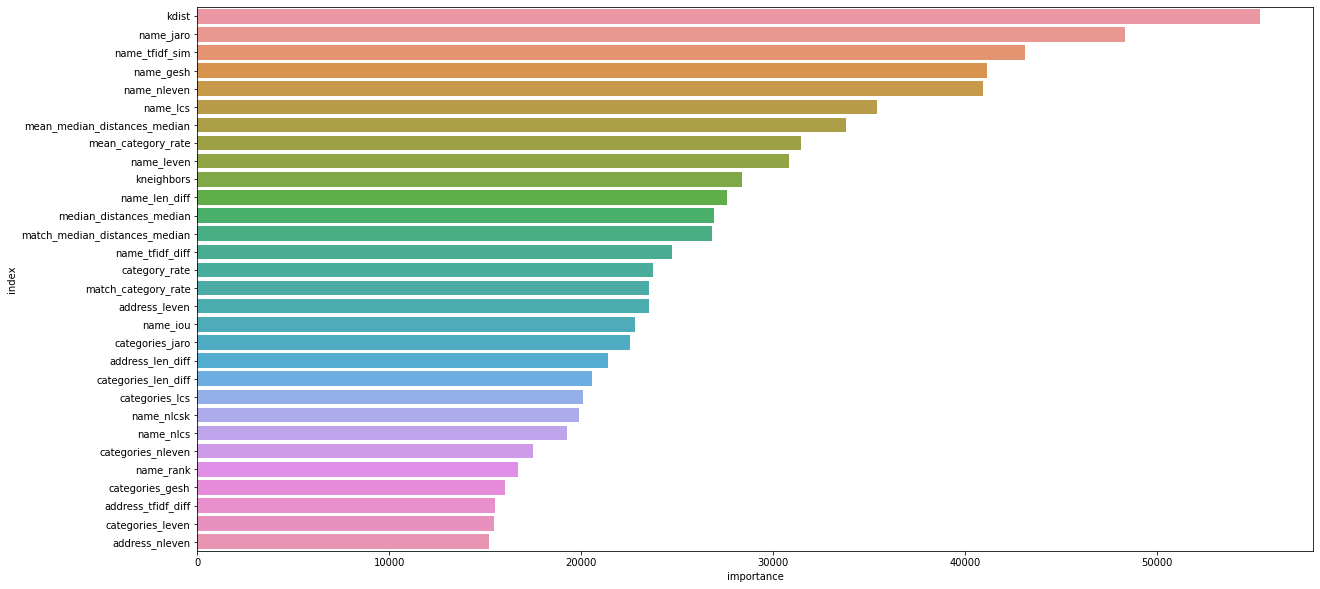

In [ ]:
importance_df = pd.DataFrame(models[0].feature_importances_, 
                             index=features, 
                             columns=['importance'])\
                    .sort_values("importance", ascending=False)


plt.figure(figsize=(20, 10))
sns.barplot(x="importance", y="index", data=importance_df.head(30).reset_index(drop=False))
plt.show()

In [ ]:
del train_X, train_y, valid_X, valid_y, models

# Change Submission Format

In [ ]:
tmp = train[['id', 'match_id', 'label']]
tmp[['pred_0', 'pred_1']] = oof

In [ ]:
tmp.to_csv(os.path.join(OUTPUT_PATH, 'oof.csv'), index = False)

### memoryリセットかけた

In [ ]:
oof = pd.read_csv(os.path.join(OUTPUT_PATH, 'oof.csv'))
oof.head()

,id,match_id,label,pred_0,pred_1
0,E_000002eae2a589,E_000002eae2a589,1,0.000003,0.999997
1,E_000007f24ebc95,E_000007f24ebc95,1,0.000136,0.999864
2,E_000008a8ba4f48,E_000008a8ba4f48,1,0.000005,0.999995
3,E_00001d92066153,E_00001d92066153,1,0.000002,0.999998
4,E_000023d8f4be44,E_000023d8f4be44,1,0.000003,0.999997


In [ ]:
y_true = pd.read_csv(os.path.join(INPUT_PATH, 'train.csv'))[['id', 'point_of_interest']]
def get_id2poi(input_df: pd.DataFrame) -> dict:
    return dict(zip(input_df['id'], input_df['point_of_interest']))

def get_poi2ids(input_df: pd.DataFrame) -> dict:
    return input_df.groupby('point_of_interest')['id'].apply(set).to_dict()

id2poi = get_id2poi(y_true)
poi2ids = get_poi2ids(y_true)
del y_true

In [ ]:
ids = list(oof.id.unique())
oof_pred = {
   id_x: [id_x] for id_x in ids
}

for idx, row in tqdm(oof.iterrows()):
    if row['pred_0'] < row['pred_1']:
        oof_pred[row['id']].append(row['match_id'])



0it [00:00, ?it/s]

In [ ]:
scores = []
for id_x in tqdm(ids):
    preds = set(oof_pred[id_x])
    targets = poi2ids[id2poi[id_x]]
    score = len((targets & preds)) / len((targets | preds))
    scores.append(score)
print('cv score is', np.array(scores).mean())
# 0.8643
# 0.8655

  0%|          | 0/1138812 [00:00<?, ?it/s]

cv score is 0.8642638388258779


In [68]:
from copy import deepcopy
def post_process(id2match):
    id2match_ = deepcopy(id2match)
    for base, match in id2match_.items():
        if len(match) == 1:        
            continue

        for m in match:
            if base not in id2match[m]:
                id2match[m].append(base)
    return id2match

In [69]:
oof_pred_ = post_process(oof_pred)
scores = []
for id_x in tqdm(ids):
    preds = set(oof_pred_[id_x])
    targets = poi2ids[id2poi[id_x]]
    score = len((targets & preds)) / len((targets | preds))
    scores.append(score)
print('cv score is', np.array(scores).mean())
# 0.8643
# 0.8655

  0%|          | 0/1138812 [00:00<?, ?it/s]

cv score is 0.867342791134068


# Tune threshold

In [ ]:
!pip install optuna

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [ ]:
import optuna

def objective(trial):

    threshold = trial.suggest_uniform('threshold', 0, 1)

    ids = list(oof.id.unique())
    oof_pred = {
      id_x: [id_x] for id_x in ids
    }

    for idx, row in tqdm(oof.iterrows()):
        if threshold < row['pred_1']:
            oof_pred[row['id']].append(row['match_id'])

    oof_pred = post_process(oof_pred)

    scores = []
    for id_x in tqdm(ids):
        preds = set(oof_pred[id_x])
        targets = poi2ids[id2poi[id_x]]
        score = len((targets & preds)) / len((targets | preds))
        scores.append(score)
    cv = np.array(scores).mean()
    print('cv score is', cv)
    return cv

study = optuna.create_study(direction='maximize')
study.optimize(objective, n_trials=100)

[I 2022-06-29 08:32:36,869] A new study created in memory with name: no-name-f5c6a60c-2d4b-4a18-ad73-e349676cd328


0it [00:00, ?it/s]

  0%|          | 0/1138812 [00:00<?, ?it/s]

[I 2022-06-29 08:41:49,727] Trial 0 finished with value: 0.8605457716146778 and parameters: {'threshold': 0.74757211242331}. Best is trial 0 with value: 0.8605457716146778.


cv score is 0.8605457716146778


0it [00:00, ?it/s]

  0%|          | 0/1138812 [00:00<?, ?it/s]

[I 2022-06-29 08:51:10,728] Trial 1 finished with value: 0.8352339419208119 and parameters: {'threshold': 0.15517301105276537}. Best is trial 0 with value: 0.8605457716146778.


cv score is 0.8352339419208119


0it [00:00, ?it/s]

  0%|          | 0/1138812 [00:00<?, ?it/s]

[I 2022-06-29 09:00:32,117] Trial 2 finished with value: 0.8316143441973866 and parameters: {'threshold': 0.9098675829450076}. Best is trial 0 with value: 0.8605457716146778.


cv score is 0.8316143441973866


0it [00:00, ?it/s]

  0%|          | 0/1138812 [00:00<?, ?it/s]

cv score is 0.7963615976703038


[I 2022-06-29 09:10:01,825] Trial 3 finished with value: 0.7963615976703038 and parameters: {'threshold': 0.06986315045025793}. Best is trial 0 with value: 0.8605457716146778.


0it [00:00, ?it/s]

  0%|          | 0/1138812 [00:00<?, ?it/s]

[I 2022-06-29 09:19:06,826] Trial 4 finished with value: 0.8575807582131159 and parameters: {'threshold': 0.7809655339304447}. Best is trial 0 with value: 0.8605457716146778.


cv score is 0.8575807582131159


0it [00:00, ?it/s]

  0%|          | 0/1138812 [00:00<?, ?it/s]

cv score is 0.8004193809205475


[I 2022-06-29 09:28:25,332] Trial 5 finished with value: 0.8004193809205475 and parameters: {'threshold': 0.9605758849945081}. Best is trial 0 with value: 0.8605457716146778.


0it [00:00, ?it/s]

  0%|          | 0/1138812 [00:00<?, ?it/s]

[I 2022-06-29 09:37:30,998] Trial 6 finished with value: 0.7709615890228266 and parameters: {'threshold': 0.9806923375826199}. Best is trial 0 with value: 0.8605457716146778.


cv score is 0.7709615890228266


0it [00:00, ?it/s]

  0%|          | 0/1138812 [00:00<?, ?it/s]

[I 2022-06-29 09:46:39,393] Trial 7 finished with value: 0.8617494463993348 and parameters: {'threshold': 0.7314191739362316}. Best is trial 7 with value: 0.8617494463993348.


cv score is 0.8617494463993348


0it [00:00, ?it/s]

  0%|          | 0/1138812 [00:00<?, ?it/s]

[I 2022-06-29 09:55:48,536] Trial 8 finished with value: 0.867558551664709 and parameters: {'threshold': 0.5133393551262624}. Best is trial 8 with value: 0.867558551664709.


cv score is 0.867558551664709


0it [00:00, ?it/s]

  0%|          | 0/1138812 [00:00<?, ?it/s]

[I 2022-06-29 10:05:08,816] Trial 9 finished with value: 0.8619423491714789 and parameters: {'threshold': 0.3501334859414299}. Best is trial 8 with value: 0.867558551664709.


cv score is 0.8619423491714789


0it [00:00, ?it/s]

  0%|          | 0/1138812 [00:00<?, ?it/s]

[I 2022-06-29 10:14:39,645] Trial 10 finished with value: 0.8671307355500869 and parameters: {'threshold': 0.48149218961755536}. Best is trial 8 with value: 0.867558551664709.


cv score is 0.8671307355500869


0it [00:00, ?it/s]

  0%|          | 0/1138812 [00:00<?, ?it/s]

[I 2022-06-29 10:23:55,178] Trial 11 finished with value: 0.8665739729733474 and parameters: {'threshold': 0.4566359688977519}. Best is trial 8 with value: 0.867558551664709.


cv score is 0.8665739729733474


0it [00:00, ?it/s]

  0%|          | 0/1138812 [00:00<?, ?it/s]

[I 2022-06-29 10:33:11,479] Trial 12 finished with value: 0.86758060377002 and parameters: {'threshold': 0.5561312223245468}. Best is trial 12 with value: 0.86758060377002.


cv score is 0.86758060377002


0it [00:00, ?it/s]

  0%|          | 0/1138812 [00:00<?, ?it/s]

[I 2022-06-29 10:42:24,104] Trial 13 finished with value: 0.8670140802396711 and parameters: {'threshold': 0.6072622211063857}. Best is trial 12 with value: 0.86758060377002.


cv score is 0.8670140802396711


0it [00:00, ?it/s]

  0%|          | 0/1138812 [00:00<?, ?it/s]

[I 2022-06-29 10:51:34,646] Trial 14 finished with value: 0.8573038861179068 and parameters: {'threshold': 0.29131008184151985}. Best is trial 12 with value: 0.86758060377002.


cv score is 0.8573038861179068


0it [00:00, ?it/s]

  0%|          | 0/1138812 [00:00<?, ?it/s]

[I 2022-06-29 11:00:51,730] Trial 15 finished with value: 0.8667824958747906 and parameters: {'threshold': 0.61896555947539}. Best is trial 12 with value: 0.86758060377002.


cv score is 0.8667824958747906


0it [00:00, ?it/s]

  0%|          | 0/1138812 [00:00<?, ?it/s]

[I 2022-06-29 11:10:11,204] Trial 16 finished with value: 0.860438912019209 and parameters: {'threshold': 0.32907966379286774}. Best is trial 12 with value: 0.86758060377002.


cv score is 0.860438912019209


0it [00:00, ?it/s]

  0%|          | 0/1138812 [00:00<?, ?it/s]

[I 2022-06-29 11:19:18,528] Trial 17 finished with value: 0.8668507286991974 and parameters: {'threshold': 0.6149510668755339}. Best is trial 12 with value: 0.86758060377002.


cv score is 0.8668507286991974


0it [00:00, ?it/s]

  0%|          | 0/1138812 [00:00<?, ?it/s]

[I 2022-06-29 11:28:31,969] Trial 18 finished with value: 0.865523715240667 and parameters: {'threshold': 0.4229742019738594}. Best is trial 12 with value: 0.86758060377002.


cv score is 0.865523715240667


0it [00:00, ?it/s]

  0%|          | 0/1138812 [00:00<?, ?it/s]

cv score is 0.8416736599799094


[I 2022-06-29 11:37:52,068] Trial 19 finished with value: 0.8416736599799094 and parameters: {'threshold': 0.1824158776680419}. Best is trial 12 with value: 0.86758060377002.


0it [00:00, ?it/s]

  0%|          | 0/1138812 [00:00<?, ?it/s]

[I 2022-06-29 11:47:10,244] Trial 20 finished with value: 0.8675825639836483 and parameters: {'threshold': 0.5556539806240105}. Best is trial 20 with value: 0.8675825639836483.


cv score is 0.8675825639836483


0it [00:00, ?it/s]

  0%|          | 0/1138812 [00:00<?, ?it/s]

[I 2022-06-29 11:56:29,888] Trial 21 finished with value: 0.8675087596087327 and parameters: {'threshold': 0.5700325905024931}. Best is trial 20 with value: 0.8675825639836483.


cv score is 0.8675087596087327


0it [00:00, ?it/s]

  0%|          | 0/1138812 [00:00<?, ?it/s]

[I 2022-06-29 12:05:44,973] Trial 22 finished with value: 0.8676603960053512 and parameters: {'threshold': 0.5466224212361356}. Best is trial 22 with value: 0.8676603960053512.


cv score is 0.8676603960053512


0it [00:00, ?it/s]

  0%|          | 0/1138812 [00:00<?, ?it/s]

[I 2022-06-29 12:14:53,415] Trial 23 finished with value: 0.8636005481668593 and parameters: {'threshold': 0.7022814260503824}. Best is trial 22 with value: 0.8676603960053512.


cv score is 0.8636005481668593


0it [00:00, ?it/s]

  0%|          | 0/1138812 [00:00<?, ?it/s]

[I 2022-06-29 12:24:03,426] Trial 24 finished with value: 0.8491276544694514 and parameters: {'threshold': 0.8425114601003025}. Best is trial 22 with value: 0.8676603960053512.


cv score is 0.8491276544694514


0it [00:00, ?it/s]

  0%|          | 0/1138812 [00:00<?, ?it/s]

[I 2022-06-29 12:33:21,543] Trial 25 finished with value: 0.8644398126736439 and parameters: {'threshold': 0.3962425567247513}. Best is trial 22 with value: 0.8676603960053512.


cv score is 0.8644398126736439


0it [00:00, ?it/s]

  0%|          | 0/1138812 [00:00<?, ?it/s]

cv score is 0.8676701653287917


[I 2022-06-29 12:42:39,656] Trial 26 finished with value: 0.8676701653287917 and parameters: {'threshold': 0.5437186247757547}. Best is trial 26 with value: 0.8676701653287917.


0it [00:00, ?it/s]

  0%|          | 0/1138812 [00:00<?, ?it/s]

[I 2022-06-29 12:51:50,302] Trial 27 finished with value: 0.8654064249054482 and parameters: {'threshold': 0.6627073771134605}. Best is trial 26 with value: 0.8676701653287917.


cv score is 0.8654064249054482


0it [00:00, ?it/s]

  0%|          | 0/1138812 [00:00<?, ?it/s]

[I 2022-06-29 13:01:08,453] Trial 28 finished with value: 0.8530413917208233 and parameters: {'threshold': 0.25212752128325466}. Best is trial 26 with value: 0.8676701653287917.


cv score is 0.8530413917208233


0it [00:00, ?it/s]

  0%|          | 0/1138812 [00:00<?, ?it/s]

[I 2022-06-29 13:10:18,885] Trial 29 finished with value: 0.8560165664255931 and parameters: {'threshold': 0.7952078604155317}. Best is trial 26 with value: 0.8676701653287917.


cv score is 0.8560165664255931


0it [00:00, ?it/s]

  0%|          | 0/1138812 [00:00<?, ?it/s]

[I 2022-06-29 13:19:28,732] Trial 30 finished with value: 0.8675549307385065 and parameters: {'threshold': 0.5131805687236511}. Best is trial 26 with value: 0.8676701653287917.


cv score is 0.8675549307385065


0it [00:00, ?it/s]

  0%|          | 0/1138812 [00:00<?, ?it/s]

[I 2022-06-29 13:28:43,511] Trial 31 finished with value: 0.8675973670832062 and parameters: {'threshold': 0.5544771557890338}. Best is trial 26 with value: 0.8676701653287917.


cv score is 0.8675973670832062


0it [00:00, ?it/s]

  0%|          | 0/1138812 [00:00<?, ?it/s]

[I 2022-06-29 13:37:57,687] Trial 32 finished with value: 0.8656489891436573 and parameters: {'threshold': 0.6565522953080359}. Best is trial 26 with value: 0.8676701653287917.


cv score is 0.8656489891436573


0it [00:00, ?it/s]

  0%|          | 0/1138812 [00:00<?, ?it/s]

cv score is 0.8649056227489472


[I 2022-06-29 13:47:16,341] Trial 33 finished with value: 0.8649056227489472 and parameters: {'threshold': 0.40619562460570535}. Best is trial 26 with value: 0.8676701653287917.


0it [00:00, ?it/s]

  0%|          | 0/1138812 [00:00<?, ?it/s]

[I 2022-06-29 13:56:32,660] Trial 34 finished with value: 0.8676457375485948 and parameters: {'threshold': 0.5484701483522972}. Best is trial 26 with value: 0.8676701653287917.


cv score is 0.8676457375485948


0it [00:00, ?it/s]

  0%|          | 0/1138812 [00:00<?, ?it/s]

[I 2022-06-29 14:05:57,223] Trial 35 finished with value: 0.8673108227583376 and parameters: {'threshold': 0.4964632359553524}. Best is trial 26 with value: 0.8676701653287917.


cv score is 0.8673108227583376


0it [00:00, ?it/s]

  0%|          | 0/1138812 [00:00<?, ?it/s]

cv score is 0.7313153752648933


[I 2022-06-29 14:15:46,605] Trial 36 finished with value: 0.7313153752648933 and parameters: {'threshold': 0.025085000565691407}. Best is trial 26 with value: 0.8676701653287917.


0it [00:00, ?it/s]

  0%|          | 0/1138812 [00:00<?, ?it/s]

[I 2022-06-29 14:25:13,054] Trial 37 finished with value: 0.8632338402306434 and parameters: {'threshold': 0.7094945532472097}. Best is trial 26 with value: 0.8676701653287917.


cv score is 0.8632338402306434


0it [00:00, ?it/s]

  0%|          | 0/1138812 [00:00<?, ?it/s]

[I 2022-06-29 14:34:30,517] Trial 38 finished with value: 0.8665759699766196 and parameters: {'threshold': 0.4566733566002796}. Best is trial 26 with value: 0.8676701653287917.


cv score is 0.8665759699766196


0it [00:00, ?it/s]

  0%|          | 0/1138812 [00:00<?, ?it/s]

[I 2022-06-29 14:43:44,946] Trial 39 finished with value: 0.8519795899114443 and parameters: {'threshold': 0.8252676109904964}. Best is trial 26 with value: 0.8676701653287917.


cv score is 0.8519795899114443


0it [00:00, ?it/s]

  0%|          | 0/1138812 [00:00<?, ?it/s]

[I 2022-06-29 14:52:54,016] Trial 40 finished with value: 0.8675774156153944 and parameters: {'threshold': 0.5562335388289101}. Best is trial 26 with value: 0.8676701653287917.


cv score is 0.8675774156153944


0it [00:00, ?it/s]

  0%|          | 0/1138812 [00:00<?, ?it/s]

[I 2022-06-29 15:02:09,606] Trial 41 finished with value: 0.8675510642019805 and parameters: {'threshold': 0.5671794207786331}. Best is trial 26 with value: 0.8676701653287917.


cv score is 0.8675510642019805


0it [00:00, ?it/s]

  0%|          | 0/1138812 [00:00<?, ?it/s]

[I 2022-06-29 15:11:33,542] Trial 42 finished with value: 0.8654485665892205 and parameters: {'threshold': 0.6619740464975847}. Best is trial 26 with value: 0.8676701653287917.


cv score is 0.8654485665892205


0it [00:00, ?it/s]

  0%|          | 0/1138812 [00:00<?, ?it/s]

cv score is 0.8676819412059794


[I 2022-06-29 15:20:47,957] Trial 43 finished with value: 0.8676819412059794 and parameters: {'threshold': 0.5326408542490791}. Best is trial 43 with value: 0.8676819412059794.


0it [00:00, ?it/s]

  0%|          | 0/1138812 [00:00<?, ?it/s]

[I 2022-06-29 15:29:55,104] Trial 44 finished with value: 0.8636482689621084 and parameters: {'threshold': 0.38013318686667863}. Best is trial 43 with value: 0.8676819412059794.


cv score is 0.8636482689621084


0it [00:00, ?it/s]

  0%|          | 0/1138812 [00:00<?, ?it/s]

cv score is 0.8664051523707843


[I 2022-06-29 15:39:10,029] Trial 45 finished with value: 0.8664051523707843 and parameters: {'threshold': 0.45056703729630193}. Best is trial 43 with value: 0.8676819412059794.


0it [00:00, ?it/s]

  0%|          | 0/1138812 [00:00<?, ?it/s]

cv score is 0.8673389664336998


[I 2022-06-29 15:48:19,555] Trial 46 finished with value: 0.8673389664336998 and parameters: {'threshold': 0.4991121150770149}. Best is trial 43 with value: 0.8676819412059794.


0it [00:00, ?it/s]

  0%|          | 0/1138812 [00:00<?, ?it/s]

[I 2022-06-29 15:57:21,436] Trial 47 finished with value: 0.8591803388221411 and parameters: {'threshold': 0.7638534852191452}. Best is trial 43 with value: 0.8676819412059794.


cv score is 0.8591803388221411


0it [00:00, ?it/s]

  0%|          | 0/1138812 [00:00<?, ?it/s]

[I 2022-06-29 16:06:28,871] Trial 48 finished with value: 0.8671683814275326 and parameters: {'threshold': 0.596936685251094}. Best is trial 43 with value: 0.8676819412059794.


cv score is 0.8671683814275326


0it [00:00, ?it/s]

  0%|          | 0/1138812 [00:00<?, ?it/s]

[I 2022-06-29 16:15:38,986] Trial 49 finished with value: 0.8676821749317899 and parameters: {'threshold': 0.5313445676009722}. Best is trial 49 with value: 0.8676821749317899.


cv score is 0.8676821749317899


0it [00:00, ?it/s]

  0%|          | 0/1138812 [00:00<?, ?it/s]

[I 2022-06-29 16:24:49,652] Trial 50 finished with value: 0.867612785546369 and parameters: {'threshold': 0.5187106383813465}. Best is trial 49 with value: 0.8676821749317899.


cv score is 0.867612785546369


0it [00:00, ?it/s]

  0%|          | 0/1138812 [00:00<?, ?it/s]

[I 2022-06-29 16:34:00,924] Trial 51 finished with value: 0.8675712423486571 and parameters: {'threshold': 0.5144374772796749}. Best is trial 49 with value: 0.8676821749317899.


cv score is 0.8675712423486571


0it [00:00, ?it/s]

  0%|          | 0/1138812 [00:00<?, ?it/s]

[I 2022-06-29 16:43:11,474] Trial 52 finished with value: 0.8662047161336769 and parameters: {'threshold': 0.4442122108929605}. Best is trial 49 with value: 0.8676821749317899.


cv score is 0.8662047161336769


0it [00:00, ?it/s]

  0%|          | 0/1138812 [00:00<?, ?it/s]

[I 2022-06-29 16:52:14,891] Trial 53 finished with value: 0.8662056520831196 and parameters: {'threshold': 0.6406335361936752}. Best is trial 49 with value: 0.8676821749317899.


cv score is 0.8662056520831196


0it [00:00, ?it/s]

  0%|          | 0/1138812 [00:00<?, ?it/s]

[I 2022-06-29 17:01:29,872] Trial 54 finished with value: 0.8676504625613535 and parameters: {'threshold': 0.5238205463759725}. Best is trial 49 with value: 0.8676821749317899.


cv score is 0.8676504625613535


0it [00:00, ?it/s]

  0%|          | 0/1138812 [00:00<?, ?it/s]

[I 2022-06-29 17:10:39,960] Trial 55 finished with value: 0.8607463710231462 and parameters: {'threshold': 0.33316650343672594}. Best is trial 49 with value: 0.8676821749317899.


cv score is 0.8607463710231462


0it [00:00, ?it/s]

  0%|          | 0/1138812 [00:00<?, ?it/s]

[I 2022-06-29 17:19:45,906] Trial 56 finished with value: 0.8673862690229712 and parameters: {'threshold': 0.5839667738869622}. Best is trial 49 with value: 0.8676821749317899.


cv score is 0.8673862690229712


0it [00:00, ?it/s]

  0%|          | 0/1138812 [00:00<?, ?it/s]

[I 2022-06-29 17:28:55,120] Trial 57 finished with value: 0.8669356451714297 and parameters: {'threshold': 0.47305017831070495}. Best is trial 49 with value: 0.8676821749317899.


cv score is 0.8669356451714297


0it [00:00, ?it/s]

  0%|          | 0/1138812 [00:00<?, ?it/s]

[I 2022-06-29 17:38:02,247] Trial 58 finished with value: 0.8637324271352301 and parameters: {'threshold': 0.6999037884279257}. Best is trial 49 with value: 0.8676821749317899.


cv score is 0.8637324271352301


0it [00:00, ?it/s]

  0%|          | 0/1138812 [00:00<?, ?it/s]

[I 2022-06-29 17:47:17,101] Trial 59 finished with value: 0.8626859110893288 and parameters: {'threshold': 0.36265228599304317}. Best is trial 49 with value: 0.8676821749317899.


cv score is 0.8626859110893288


0it [00:00, ?it/s]

  0%|          | 0/1138812 [00:00<?, ?it/s]

[I 2022-06-29 17:56:29,465] Trial 60 finished with value: 0.8676580419123463 and parameters: {'threshold': 0.5375788553960005}. Best is trial 49 with value: 0.8676821749317899.


cv score is 0.8676580419123463


0it [00:00, ?it/s]

  0%|          | 0/1138812 [00:00<?, ?it/s]

[I 2022-06-29 18:05:42,945] Trial 61 finished with value: 0.8666712817937655 and parameters: {'threshold': 0.6240038533152436}. Best is trial 49 with value: 0.8676821749317899.


cv score is 0.8666712817937655


0it [00:00, ?it/s]

  0%|          | 0/1138812 [00:00<?, ?it/s]

[I 2022-06-29 18:14:48,521] Trial 62 finished with value: 0.8676707012791783 and parameters: {'threshold': 0.5290497212331977}. Best is trial 49 with value: 0.8676821749317899.


cv score is 0.8676707012791783


0it [00:00, ?it/s]

  0%|          | 0/1138812 [00:00<?, ?it/s]

[I 2022-06-29 18:23:35,762] Trial 63 finished with value: 0.8676790428346334 and parameters: {'threshold': 0.5344156225182175}. Best is trial 49 with value: 0.8676821749317899.


cv score is 0.8676790428346334


0it [00:00, ?it/s]

  0%|          | 0/1138812 [00:00<?, ?it/s]

[I 2022-06-29 18:32:20,622] Trial 64 finished with value: 0.8652890355417845 and parameters: {'threshold': 0.4166199344535479}. Best is trial 49 with value: 0.8676821749317899.


cv score is 0.8652890355417845


0it [00:00, ?it/s]

  0%|          | 0/1138812 [00:00<?, ?it/s]

[I 2022-06-29 18:41:02,004] Trial 65 finished with value: 0.8670784066687095 and parameters: {'threshold': 0.6014120536765449}. Best is trial 49 with value: 0.8676821749317899.


cv score is 0.8670784066687095


0it [00:00, ?it/s]

  0%|          | 0/1138812 [00:00<?, ?it/s]

cv score is 0.8668767932241678


[I 2022-06-29 18:49:46,754] Trial 66 finished with value: 0.8668767932241678 and parameters: {'threshold': 0.47091697282523526}. Best is trial 49 with value: 0.8676821749317899.


0it [00:00, ?it/s]

  0%|          | 0/1138812 [00:00<?, ?it/s]

cv score is 0.8656030345887784


[I 2022-06-29 18:58:31,487] Trial 67 finished with value: 0.8656030345887784 and parameters: {'threshold': 0.4252317257036445}. Best is trial 49 with value: 0.8676821749317899.


0it [00:00, ?it/s]

  0%|          | 0/1138812 [00:00<?, ?it/s]

[I 2022-06-29 19:07:15,732] Trial 68 finished with value: 0.8676776301636031 and parameters: {'threshold': 0.5348136392153328}. Best is trial 49 with value: 0.8676821749317899.


cv score is 0.8676776301636031


0it [00:00, ?it/s]

  0%|          | 0/1138812 [00:00<?, ?it/s]

cv score is 0.867267037279117


[I 2022-06-29 19:15:56,042] Trial 69 finished with value: 0.867267037279117 and parameters: {'threshold': 0.4916704760901396}. Best is trial 49 with value: 0.8676821749317899.


0it [00:00, ?it/s]

  0%|          | 0/1138812 [00:00<?, ?it/s]

[I 2022-06-29 19:24:37,629] Trial 70 finished with value: 0.864453436583284 and parameters: {'threshold': 0.6858135718876095}. Best is trial 49 with value: 0.8676821749317899.


cv score is 0.864453436583284


0it [00:00, ?it/s]

  0%|          | 0/1138812 [00:00<?, ?it/s]

cv score is 0.867658153414892


[I 2022-06-29 19:33:19,344] Trial 71 finished with value: 0.867658153414892 and parameters: {'threshold': 0.537855247435417}. Best is trial 49 with value: 0.8676821749317899.


0it [00:00, ?it/s]

  0%|          | 0/1138812 [00:00<?, ?it/s]

[I 2022-06-29 19:41:58,214] Trial 72 finished with value: 0.8674628801345147 and parameters: {'threshold': 0.5768347006687364}. Best is trial 49 with value: 0.8676821749317899.


cv score is 0.8674628801345147


0it [00:00, ?it/s]

  0%|          | 0/1138812 [00:00<?, ?it/s]

[I 2022-06-29 19:50:38,481] Trial 73 finished with value: 0.8671039574716318 and parameters: {'threshold': 0.5995435853787651}. Best is trial 49 with value: 0.8676821749317899.


cv score is 0.8671039574716318


0it [00:00, ?it/s]

  0%|          | 0/1138812 [00:00<?, ?it/s]

[I 2022-06-29 19:59:19,919] Trial 74 finished with value: 0.8663673841725902 and parameters: {'threshold': 0.6344218130756912}. Best is trial 49 with value: 0.8676821749317899.


cv score is 0.8663673841725902


0it [00:00, ?it/s]

  0%|          | 0/1138812 [00:00<?, ?it/s]

cv score is 0.8676764859171727


[I 2022-06-29 20:08:02,378] Trial 75 finished with value: 0.8676764859171727 and parameters: {'threshold': 0.5430928062244436}. Best is trial 49 with value: 0.8676821749317899.


0it [00:00, ?it/s]

  0%|          | 0/1138812 [00:00<?, ?it/s]

[I 2022-06-29 20:16:46,789] Trial 76 finished with value: 0.867168344928167 and parameters: {'threshold': 0.48411237084691366}. Best is trial 49 with value: 0.8676821749317899.


cv score is 0.867168344928167


0it [00:00, ?it/s]

  0%|          | 0/1138812 [00:00<?, ?it/s]

cv score is 0.8202632781070065


[I 2022-06-29 20:25:24,716] Trial 77 finished with value: 0.8202632781070065 and parameters: {'threshold': 0.9342368082428021}. Best is trial 49 with value: 0.8676821749317899.


0it [00:00, ?it/s]

  0%|          | 0/1138812 [00:00<?, ?it/s]

cv score is 0.8659696156688547


[I 2022-06-29 20:34:06,962] Trial 78 finished with value: 0.8659696156688547 and parameters: {'threshold': 0.4370350144444155}. Best is trial 49 with value: 0.8676821749317899.


0it [00:00, ?it/s]

  0%|          | 0/1138812 [00:00<?, ?it/s]

[I 2022-06-29 20:42:48,717] Trial 79 finished with value: 0.8575170482397604 and parameters: {'threshold': 0.29382585526780686}. Best is trial 49 with value: 0.8676821749317899.


cv score is 0.8575170482397604


0it [00:00, ?it/s]

  0%|          | 0/1138812 [00:00<?, ?it/s]

[I 2022-06-29 20:51:31,405] Trial 80 finished with value: 0.867662391090071 and parameters: {'threshold': 0.5369393303688244}. Best is trial 49 with value: 0.8676821749317899.


cv score is 0.867662391090071


0it [00:00, ?it/s]

  0%|          | 0/1138812 [00:00<?, ?it/s]

[I 2022-06-29 21:00:12,997] Trial 81 finished with value: 0.867465431231939 and parameters: {'threshold': 0.5748814616057111}. Best is trial 49 with value: 0.8676821749317899.


cv score is 0.867465431231939


0it [00:00, ?it/s]

  0%|          | 0/1138812 [00:00<?, ?it/s]

[I 2022-06-29 21:08:55,855] Trial 82 finished with value: 0.8676636174875978 and parameters: {'threshold': 0.535735085710744}. Best is trial 49 with value: 0.8676821749317899.


cv score is 0.8676636174875978


0it [00:00, ?it/s]

  0%|          | 0/1138812 [00:00<?, ?it/s]

cv score is 0.8676183316106445


[I 2022-06-29 21:17:37,280] Trial 83 finished with value: 0.8676183316106445 and parameters: {'threshold': 0.5203591647724719}. Best is trial 49 with value: 0.8676821749317899.


0it [00:00, ?it/s]

  0%|          | 0/1138812 [00:00<?, ?it/s]

[I 2022-06-29 21:26:21,914] Trial 84 finished with value: 0.8668747855130086 and parameters: {'threshold': 0.47058579424825003}. Best is trial 49 with value: 0.8676821749317899.


cv score is 0.8668747855130086


0it [00:00, ?it/s]

  0%|          | 0/1138812 [00:00<?, ?it/s]

[I 2022-06-29 21:35:05,146] Trial 85 finished with value: 0.8676800278725608 and parameters: {'threshold': 0.543279987585304}. Best is trial 49 with value: 0.8676821749317899.


cv score is 0.8676800278725608


0it [00:00, ?it/s]

  0%|          | 0/1138812 [00:00<?, ?it/s]

[I 2022-06-29 21:43:46,483] Trial 86 finished with value: 0.8668391793185306 and parameters: {'threshold': 0.6157469646777938}. Best is trial 49 with value: 0.8676821749317899.


cv score is 0.8668391793185306


0it [00:00, ?it/s]

  0%|          | 0/1138812 [00:00<?, ?it/s]

[I 2022-06-29 21:52:28,256] Trial 87 finished with value: 0.8673789600623393 and parameters: {'threshold': 0.5023857695174709}. Best is trial 49 with value: 0.8676821749317899.


cv score is 0.8673789600623393


0it [00:00, ?it/s]

  0%|          | 0/1138812 [00:00<?, ?it/s]

cv score is 0.8674664174125898


[I 2022-06-29 22:01:11,108] Trial 88 finished with value: 0.8674664174125898 and parameters: {'threshold': 0.5725522002657035}. Best is trial 49 with value: 0.8676821749317899.


0it [00:00, ?it/s]

  0%|          | 0/1138812 [00:00<?, ?it/s]

cv score is 0.8641585948638426


[I 2022-06-29 22:09:53,913] Trial 89 finished with value: 0.8641585948638426 and parameters: {'threshold': 0.3903527087868729}. Best is trial 49 with value: 0.8676821749317899.


0it [00:00, ?it/s]

  0%|          | 0/1138812 [00:00<?, ?it/s]

[I 2022-06-29 22:18:36,688] Trial 90 finished with value: 0.8659320012797956 and parameters: {'threshold': 0.6494953493571187}. Best is trial 49 with value: 0.8676821749317899.


cv score is 0.8659320012797956


0it [00:00, ?it/s]

  0%|          | 0/1138812 [00:00<?, ?it/s]

[I 2022-06-29 22:27:21,867] Trial 91 finished with value: 0.8676572959119786 and parameters: {'threshold': 0.5473579022731375}. Best is trial 49 with value: 0.8676821749317899.


cv score is 0.8676572959119786


0it [00:00, ?it/s]

  0%|          | 0/1138812 [00:00<?, ?it/s]

[I 2022-06-29 22:36:06,219] Trial 92 finished with value: 0.8676736614589592 and parameters: {'threshold': 0.5343401012325263}. Best is trial 49 with value: 0.8676821749317899.


cv score is 0.8676736614589592


0it [00:00, ?it/s]

  0%|          | 0/1138812 [00:00<?, ?it/s]

cv score is 0.8672084273770924


[I 2022-06-29 22:44:48,170] Trial 93 finished with value: 0.8672084273770924 and parameters: {'threshold': 0.5955231451246773}. Best is trial 49 with value: 0.8676821749317899.


0it [00:00, ?it/s]

  0%|          | 0/1138812 [00:00<?, ?it/s]

[I 2022-06-29 22:53:33,650] Trial 94 finished with value: 0.8665752532087557 and parameters: {'threshold': 0.45632411086305946}. Best is trial 49 with value: 0.8676821749317899.


cv score is 0.8665752532087557


0it [00:00, ?it/s]

  0%|          | 0/1138812 [00:00<?, ?it/s]

[I 2022-06-29 23:02:16,541] Trial 95 finished with value: 0.8673522274008235 and parameters: {'threshold': 0.500572482049862}. Best is trial 49 with value: 0.8676821749317899.


cv score is 0.8673522274008235


0it [00:00, ?it/s]

  0%|          | 0/1138812 [00:00<?, ?it/s]

[I 2022-06-29 23:10:58,839] Trial 96 finished with value: 0.8675842365878161 and parameters: {'threshold': 0.5589560273517502}. Best is trial 49 with value: 0.8676821749317899.


cv score is 0.8675842365878161


0it [00:00, ?it/s]

  0%|          | 0/1138812 [00:00<?, ?it/s]

[I 2022-06-29 23:19:39,779] Trial 97 finished with value: 0.8676566419509841 and parameters: {'threshold': 0.5248016206453341}. Best is trial 49 with value: 0.8676821749317899.


cv score is 0.8676566419509841


0it [00:00, ?it/s]

  0%|          | 0/1138812 [00:00<?, ?it/s]

cv score is 0.8673337516290441


[I 2022-06-29 23:28:24,235] Trial 98 finished with value: 0.8673337516290441 and parameters: {'threshold': 0.5868282603935852}. Best is trial 49 with value: 0.8676821749317899.


0it [00:00, ?it/s]

  0%|          | 0/1138812 [00:00<?, ?it/s]

cv score is 0.8671335512141918


[I 2022-06-29 23:37:08,049] Trial 99 finished with value: 0.8671335512141918 and parameters: {'threshold': 0.481513888131023}. Best is trial 49 with value: 0.8676821749317899.


In [ ]:
study.best_params

{'threshold': 0.5313445676009722}

In [ ]:
study.best_value

0.8676821749317899

# Check Misclassification 

In [ ]:
oof['pred'] = oof['pred_1'].round()
tmp = oof[['id', 'match_id', 'label', 'pred', 'pred_1']]

In [ ]:
t = tmp[tmp['label']!=tmp['pred']]
tt = t[t['pred_1']<0.2]

In [ ]:
len(t)

In [ ]:
tt

In [ ]:
id = 'E_0146e712d66bb8'
m_id = 'E_512009c07275bc'
ids = [id, m_id]
data[data.index.isin(ids)]
# data[data.id.isin(ids)]

In [ ]:
train[(train['id']==id) & (train['match_id']==m_id)][['kdist', 'categories_jaro', 'name_jaro', 'categories_lcs', 'name_tfidf_sim', 'name_leven', 'name_nleven']]

In [ ]:
train.name_lcs.min()

In [ ]:
train[
    (train['kdist']==0.0) &
    (train['categories_jaro']==1.0) & 
    (train['name_jaro']==1.0) & 
    (train['label']==0)
][['id', 'match_id', 'kdist', 'categories_jaro', 'name_jaro', 'categories_lcs', 'name_tfidf_sim', 'name_leven', 'name_nleven', 'label']]

In [ ]:
train[
    (train['kdist']==0.0) &
    (train['categories_jaro']==1.0) & 
    (train['name_jaro']==1.0) & 
    (train['label']==1)
][['id', 'match_id', 'kdist', 'categories_jaro', 'name_jaro', 'categories_lcs', 'name_tfidf_sim', 'name_leven', 'name_nleven', 'label']]

In [ ]:
train.head(20)[['id', 'match_id', 'kdist', 'categories_jaro', 'name_jaro', 'categories_lcs', 'name_tfidf_sim', 'name_leven', 'name_nleven', 'label']]

In [ ]:
# cols = ['kdist_country', 'kdist', 'categories_jaro', 'name_jaro']
# train[(train['id']==id) & (train['match_id']==m_id)][cols]

In [ ]:
# train[train['kdist_country']== train['kdist']]

In [ ]:
# data[data.index.isin(ids)].loc['E_34199c1154c0d9']['name'].split()

In [ ]:
# data[data.index.isin(ids)].loc['E_0258802b17b98e']['name'].split()